# Градиентный бустинг своими руками

**Внимание:** в тексте задания произошли изменения - поменялось число деревьев (теперь 50), правило изменения величины шага в задании 3 и добавился параметр `random_state` у решающего дерева. Правильные ответы не поменялись, но теперь их проще получить. Также исправлена опечатка в функции `gbm_predict`.

В этом задании будет использоваться датасет `boston` из `sklearn.datasets`. Оставьте последние 25% объектов для контроля качества, разделив `X` и `y` на `X_train`, `y_train` и `X_test`, `y_test`.

Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

In [2]:
boston = load_boston()

In [3]:
X = boston.data
y = boston.target

In [4]:
len(X)

506

In [5]:
X_train = X[:379]
y_train = y[:379]
X_test = X[379:]
y_test = y[379:]

In [6]:
print(y_test)

[10.2 10.4 10.9 11.3 12.3  8.8  7.2 10.5  7.4 10.2 11.5 15.1 23.2  9.7
 13.8 12.7 13.1 12.5  8.5  5.   6.3  5.6  7.2 12.1  8.3  8.5  5.  11.9
 27.9 17.2 27.5 15.  17.2 17.9 16.3  7.   7.2  7.5 10.4  8.8  8.4 16.7
 14.2 20.8 13.4 11.7  8.3 10.2 10.9 11.   9.5 14.5 14.1 16.1 14.3 11.7
 13.4  9.6  8.7  8.4 12.8 10.5 17.1 18.4 15.4 10.8 11.8 14.9 12.6 14.1
 13.  13.4 15.2 16.1 17.8 14.9 14.1 12.7 13.5 14.9 20.  16.4 17.7 19.5
 20.2 21.4 19.9 19.  19.1 19.1 20.1 19.9 19.6 23.2 29.8 13.8 13.3 16.7
 12.  14.6 21.4 23.  23.7 25.  21.8 20.6 21.2 19.1 20.6 15.2  7.   8.1
 13.6 20.1 21.8 24.5 23.1 19.7 18.3 21.2 17.5 16.8 22.4 20.6 23.9 22.
 11.9]


## Задание 1

Как вы уже знаете из лекций, **бустинг** - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. 

Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки.

Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь `L` - квадрат отклонения ответа композиции `a(x)` от правильного ответа `y` на данном `x`.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. После дифференцирования квадрата у вас возникнет множитель 2 — т.к. нам все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигноируйте этот множитель при дальнейшем построении алгоритма.

## Задание 2

Заведите массив для объектов `DecisionTreeRegressor` (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). 

В цикле от обучите последовательно 50 решающих деревьев с параметрами `max_depth=5` и `random_state=42` (остальные параметры - по умолчанию). В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. 

Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.

В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке `X`:

```
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]
(считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)
```

Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью `mean_squared_error` в `sklearn.metrics`. 

Возведите результат в степень 0.5, чтобы получить `RMSE`. Полученное значение `RMSE` — **ответ в пункте 2**.

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [8]:
errors = []
def learning(X, y):
    eta = 0.9
    base_algorithms_list = [DecisionTreeRegressor(max_depth = 5, random_state = 42).fit(X,y)] # задаём базовый олгоритм 
    #и трениурем его
    coefficients_list = [eta]
    
    def gbm_predict(X):
        return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, 
                                                                             coefficients_list)]) for x in X]
    for i in range(49):
        DT = DecisionTreeRegressor(max_depth = 5, random_state = 42)

        y_predicted = gbm_predict(X) # задаём новый прогноз для очередного следующего алгоритма
        antigrad = -(y_predicted - y) # вычисляем градиент от MSE
        
        DT_fit = DT.fit(X, antigrad) # обучаем новую модель, вместо y здесь antigrad, потому что мы улучшаем первую модель
        # путём добавления к ней новой, обученной на этом смещение
        errors.append(mean_squared_error(y_predicted, y)) # добавляем MSE в список errors
        base_algorithms_list.append(DT_fit)               # добавляем алгоритм в список алгоритмов
                     
        coefficients_list.append(eta)
        print ('Номер итерации :',i,'\t', 'MSE =', mean_squared_error(y_predicted, y))
    return gbm_predict

In [9]:
GB = learning(X_train,y_train)

Номер итерации : 0 	 MSE = 12.331605457099899
Номер итерации : 1 	 MSE = 3.141636385796952
Номер итерации : 2 	 MSE = 2.124055499201814
Номер итерации : 3 	 MSE = 1.4043792015119663
Номер итерации : 4 	 MSE = 1.044955283595192
Номер итерации : 5 	 MSE = 0.6718226467537942
Номер итерации : 6 	 MSE = 0.49952057509534303
Номер итерации : 7 	 MSE = 0.35218204682222926
Номер итерации : 8 	 MSE = 0.2889922320622582
Номер итерации : 9 	 MSE = 0.1984452548657373
Номер итерации : 10 	 MSE = 0.14597519729435435
Номер итерации : 11 	 MSE = 0.1104547941861666
Номер итерации : 12 	 MSE = 0.08873097417775282
Номер итерации : 13 	 MSE = 0.07272042240399255
Номер итерации : 14 	 MSE = 0.05616586857397539
Номер итерации : 15 	 MSE = 0.04265208395104792
Номер итерации : 16 	 MSE = 0.028528788301136657
Номер итерации : 17 	 MSE = 0.020589484057948144
Номер итерации : 18 	 MSE = 0.01697116548982668
Номер итерации : 19 	 MSE = 0.011030487621622157
Номер итерации : 20 	 MSE = 0.008433798633814802
Номер итер

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


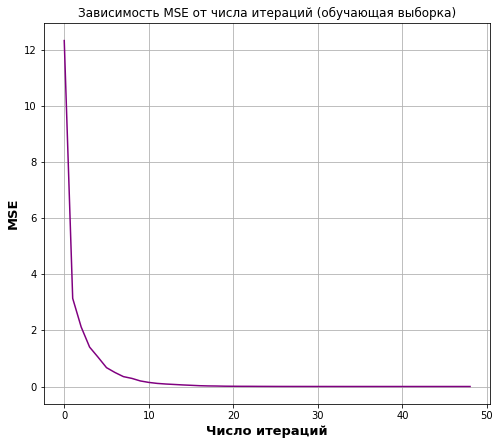

In [11]:
figure(figsize = (8,7))
plot(range(49), errors, color = 'purple')
title('Зависимость MSE от числа итераций (обучающая выборка)')
xlabel('Число итераций', fontsize = 13, fontweight = 'bold')
ylabel('MSE', fontsize = 13, fontweight = 'bold')
grid(True)

In [12]:
y_predicted = GB(X_test)
string = np.sqrt(mean_squared_error(y_test, y_predicted))
print (string)

5.455565103009404


In [13]:
def write_answer_1(string):
    with open("D:\Coursera\Boosting_answer_1.txt", "w") as file:
        file.write(str(string))

In [14]:
write_answer_1(string)

## Задание 3

Вас может также беспокоить, что двигаясь с постоянным шагом, вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. 

Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле `0.9 / (1.0 + i)`, где `i` - номер итерации (от 0 до 49). Используйте качество работы алгоритма как **ответ в пункте 3**. 

В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным. Мы не будем предлагать вам реализовать это для выполнения задания, но рекомендуем попробовать разобраться с такой стратегией и реализовать ее при случае для себя.

In [15]:
errors_new = []
eta = 0.9
coefficients_list = [eta]
def learning(X, y):
    eta = 0.9
    base_algorithms_list = [DecisionTreeRegressor(max_depth = 5, random_state = 42).fit(X,y)] # задаём базовый олгоритм 
    #и трениурем его
    coefficients_list = [eta]
    
    def gbm_predict(X):
        return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, 
                                                                             coefficients_list)]) for x in X]
    for i in range(1,50):
        DT = DecisionTreeRegressor(max_depth = 5, random_state = 42)

        y_predicted = gbm_predict(X) # задаём новый прогноз для очередного следующего алгоритма
        antigrad = -(y_predicted - y) # вычисляем градиент от MSE
        
        DT_fit = DT.fit(X, antigrad) # обучаем новую модель, вместо y здесь antigrad, потому что мы улучшаем первую модель
        # путём добавления к ней новой, обученной на этом смещение
        errors_new.append(mean_squared_error(y_predicted, y)) # добавляем MSE в список errors
        base_algorithms_list.append(DT_fit)               # добавляем алгоритм в список алгоритмов
        
        eta_new = eta/(1. + i)
        coefficients_list.append(eta_new)
        print ('Номер итерации :',i,'\t', 'MSE =', mean_squared_error(y_predicted, y), '\t', 'eta_new =', eta_new)
    return gbm_predict

In [16]:
GB_new = learning(X_train, y_train)

Номер итерации : 1 	 MSE = 12.331605457099899 	 eta_new = 0.45
Номер итерации : 2 	 MSE = 5.856854520500094 	 eta_new = 0.3
Номер итерации : 3 	 MSE = 4.024928983203765 	 eta_new = 0.225
Номер итерации : 4 	 MSE = 3.258954713501128 	 eta_new = 0.18
Номер итерации : 5 	 MSE = 2.7992073273110116 	 eta_new = 0.15
Номер итерации : 6 	 MSE = 2.425572714953782 	 eta_new = 0.1285714285714286
Номер итерации : 7 	 MSE = 2.179239548526464 	 eta_new = 0.1125
Номер итерации : 8 	 MSE = 1.9931096395335335 	 eta_new = 0.1
Номер итерации : 9 	 MSE = 1.8199712274457958 	 eta_new = 0.09
Номер итерации : 10 	 MSE = 1.699040049185483 	 eta_new = 0.08181818181818182
Номер итерации : 11 	 MSE = 1.5996568063706962 	 eta_new = 0.075
Номер итерации : 12 	 MSE = 1.5425447021847591 	 eta_new = 0.06923076923076923
Номер итерации : 13 	 MSE = 1.4885073502968151 	 eta_new = 0.0642857142857143
Номер итерации : 14 	 MSE = 1.4223897513181356 	 eta_new = 0.060000000000000005
Номер итерации : 15 	 MSE = 1.3854875408284

In [17]:
y_predicted_new = GB_new(X_test)
string_new = np.sqrt(mean_squared_error(y_test, y_predicted_new))
print (string_new)

4.812550945781194


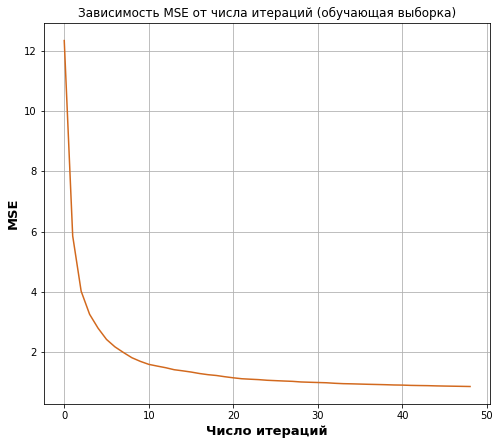

In [18]:
figure(figsize = (8,7))
plot(range(49), errors_new, color = 'chocolate')
title('Зависимость MSE от числа итераций (обучающая выборка)')
xlabel('Число итераций', fontsize = 13, fontweight = 'bold')
ylabel('MSE', fontsize = 13, fontweight = 'bold')
grid(True)

In [19]:
def write_answer_2(string_new):
    with open("D:\Coursera\Boosting_answer_2.txt", "w") as file:
        file.write(str(string_new))

In [20]:
write_answer_2(string_new)

## Задание 4

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке `sklearn`, так и в сторонней библиотеке `XGBoost`, которая имеет свой питоновский интерфейс. На практике `XGBoost` работает заметно лучше `GradientBoostingRegressor` из `sklearn`, но для этого задания вы можете использовать любую реализацию. 

Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера (это будет **ответ в п.4**):

    1. С увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно.

    2. С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.

    3. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться.

    4. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться

In [23]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

Сравним качество алгоритмов на тестовой выборке c **увеличением числа деревьев**.Также сравним время работы XGBRegressor и GradientBoostingRegressor

In [24]:
%%time
score_xgb_train = []
score_xgb_test = []
n_estimator = range(1,400, 2)
for i in n_estimator:
    estimator = xgb.XGBRegressor(n_estimators = i)
    estimator_fit = estimator.fit(X_train, y_train)
    y_predicted_test = estimator_fit.predict(X_test)
    y_predicted_train = estimator_fit.predict(X_train)
    score_xgb_train.append(np.sqrt(mean_squared_error(y_train, y_predicted_train)))
    score_xgb_test.append(np.sqrt(mean_squared_error(y_test, y_predicted_test)))

Wall time: 25.5 s


In [ ]:
#%%time
#score_GBR = []
#n_estimator = range(1,400, 2)
#for i in n_estimator:
#    estimator = GradientBoostingRegressor(n_estimators = i,)
#    estimator_fit = estimator.fit(X_train, y_train)
#    y_predicted = estimator_fit.predict(X_test)
#    score_GBR.append(np.sqrt(mean_squared_error(y_test, y_predicted)))

Изобразим графически, как ведёт себя MSE с увеличением количества деревьев

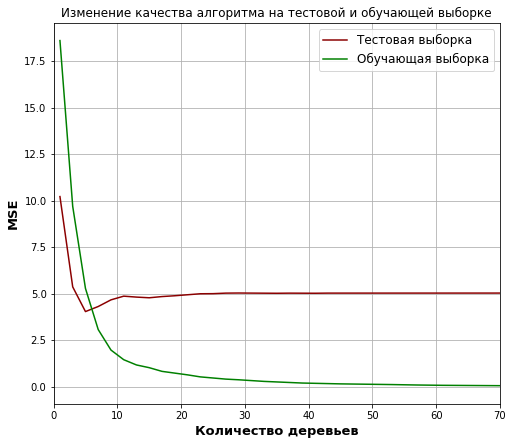

In [28]:
figure(figsize = (8,7))
plot(n_estimator, score_xgb_test, label = 'Тестовая выборка', color = 'darkred')
plot(n_estimator, score_xgb_train, label = 'Обучающая выборка', color = 'green')
#plot(n_estimator, score_GBR, label = 'GradientBoostingRegressor', color = 'forestgreen')
title('Изменение качества алгоритма на тестовой и обучающей выборке')
xlabel('Количество деревьев', fontsize = 13, fontweight = 'bold')
ylabel('MSE',fontsize = 13, fontweight = 'bold')
xlim(0,70)
grid(True)
legend(fontsize = 12)

Видно, что с увеличением числа деревьев, MSE на обучающей выборке стремиться к нулю. 
Для тестовой выборки они имеет минимум в точке 4.0346164602188574, а дальше ошибка начинает расти и выходит на плато. Итог: имеет место переобучение

Теперь посмотрим как меняется качество алгоритмов на тестовой выборке с увеличением глубины деревьев. Также сравним время расчёта

In [ ]:
#%%time
#mistake_GBR_train = []
#mistake_GBR_test = []
#max_depths = range(1,40, 1)
#for i in max_depths:
#    estimator = GradientBoostingRegressor(n_estimators = 50, max_depth = i)
#    estimator_fit = estimator.fit(X_train, y_train)
#    y_predicted_train = estimator_fit.predict(X_train)
#    y_predicted_test = estimator_fit.predict(X_test)
#    mistake_GBR_train.append(np.sqrt(mean_squared_error(y_train, y_predicted_train)))
#    mistake_GBR_test.append(np.sqrt(mean_squared_error(y_test, y_predicted_test)))

In [36]:
%%time
mistake_xgb_train = []
mistake_xgb_test = []
max_depths = range(1,40, 1)
for i in max_depths:
    estimator = xgb.XGBRegressor(max_depth = i)
    estimator_fit = estimator.fit(X_train, y_train)
    y_predicted_train = estimator_fit.predict(X_train)
    y_predicted_test = estimator_fit.predict(X_test)
    mistake_xgb_test.append(np.sqrt(mean_squared_error(y_test, y_predicted_test)))
    mistake_xgb_train.append(np.sqrt(mean_squared_error(y_train, y_predicted_train)))

Wall time: 4.11 s


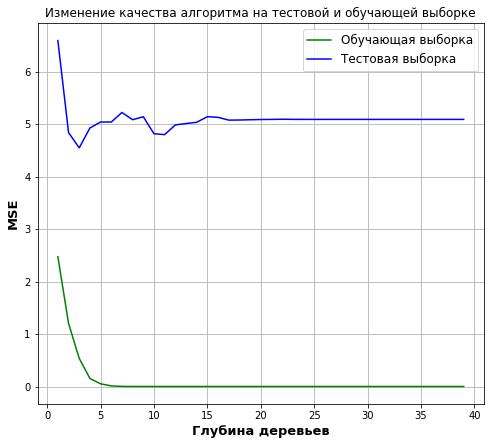

In [39]:
plt.figure(figsize = (8,7))
#plot(max_depths, mistake_GBR_train, color = 'blue',label = 'XGBRegressor' )
#plot(max_depths, mistake_GBR_test, color = 'red',label = 'XGBRegressor' )
#plot(max_depths, mistake_xgb, color = 'red', label = 'GradientBoostingRegressor')
plot(max_depths, mistake_xgb_train, color = 'green', label = 'Обучающая выборка')
plot(max_depths, mistake_xgb_test, color = 'blue', label = 'Тестовая выборка')
plt.title('Изменение качества алгоритма на тестовой и обучающей выборке')
plt.xlabel('Глубина деревьев', fontsize = 13, fontweight = 'bold')
plt.ylabel('MSE',fontsize = 13, fontweight = 'bold')
plt.grid(True)
plt.legend(fontsize = 12)
plt.grid(True)

Получаем схожую ситуацию, что и с количеством дереьвев. Ошибка MSE на тестовой выборке уменьшается до точки 4.55, а дальше
ошибка начинает расти. Снова переобучаемся

In [46]:
answer_3 = [2,3]

In [47]:
def write_answer_3(answer_3):
    with open("D:\Coursera\Boosting_answer_3.txt", "w") as file:
        file.writelines(answer_3 + ' ' for answer_3 in map(str, answer_3))

In [48]:
write_answer_3(answer_3)

## Задание 5

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. 

Для этого обучите `LinearRegression` из `sklearn.linear_model` (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке `RMSE`. Полученное качество - ответ в **пункте 5**. 

В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда. В заданиях к этому курсу вы еще встретите пример обратной ситуации.

In [140]:
from sklearn.linear_model import LinearRegression

In [153]:
model = LinearRegression()
model_fit = model.fit(X_train, y_train)
y_predicted = model_fit.predict(X_test)
error_LR = np.sqrt(mean_squared_error(y_predicted,y_test))

In [154]:
def write_answer_4(error_LR):
    with open("D:\Coursera\Boosting_answer_4.txt", "w") as file:
        file.write(str(error_LR))

In [156]:
write_answer_4(error_LR)